# 삽관/발관 데이터 페어링하고 환자군 분류

### Subjectlist DATA (고유한 환자들의 입원기록만 있는 테이블) - (7231, 5)
- subject_id: 환자 고유번호 (출처: hosp_patients)
- hadm_id: 병원 입원 고유번호 (출처: hosp_admissions)
- stay_id: 중환자실 입원 고유번호. 발관 시간 기준으로 생성. 발관시간 NULL일 경우 삽관 이벤트 활용 (출처: icu_icustays)
- admittime: 입원시각 (출처: hosp_admissions)
- dischtime: 퇴원시각 (출처: hosp_admissions)

### Intubation/Extubation DATA (삽관 발관 시간 데이터 포함된 테이블) - (9003, 29)
- subject_id: 환자 고유번호 (출처: hosp_patients)
- hadm_id: 병원 입원 고유번호 (출처: hosp_admissions)
- stay_id: 중환자실 입원 고유번호. 발관 시간 기준으로 생성. 발관시간 NULL일 경우 삽관 이벤트 활용 (출처: icu_icustays)
- gender: 성별
- los: Length of Stay (days)
- int_stayid: 삽관 당시 응급병동 입원 고유번호 (출처: icu_icustays)
- admittime: 입원시각 (출처: hosp_admissions)
- intubationtime: 삽관시각 (출처: icu_procedureevents)
- int_itemid: 삽관 아이템 코드 (itemid: 224385) (출처: icu_procedureevents)
- int_weight: 삽관 당시 체중 (출처: icu_procedureevents)
- ext_stayid: 발관 당시 응급병동 입원 고유번호 (출처: icu_icustays) (출처: icu_procedureevents)
- extubationtime: 발관시각 (출처: icu_procedureevents) (출처: icu_procedureevents)
- ext_itemid: 발관 아이템 코드 (itemid: 225468, 225477, 227194) (출처: icu_procedureevents)
- ext_weight: 발관 당시 체중 (출처: icu_procedureevents)
- extubationcause: 발관 사유 (Planned Extubation, Unplanned Extubation (patient-initiated), Unplanned Extubation (patient-uninitiated)) (출처: icu_procedureevents)
- dischtime: 퇴원시각 (출처: hosp_admissions)
- deathtime: 사망시각 (출처: hosp_admissions)
- marker: 결측값 대체가 이루어진 경우 기록 (예: 퇴원시각으로 대체 시 'dischtime imputation)
- seq_num: 삽관-발관 이벤트의 시퀀스 순서(1~n)
- reint_marker (boolean): 이 환자의 입원기록에서 재삽관 존재 시 True. 
- intext_duration: 삽관시각과 발관시각의 시간차 (단위: 분)
- reintubation_eventtime: 다음 재삽관 시간 (없을 경우 NULL)
- reintubationtime: 발관 후 재삽관까지 걸린 시간 (단위: 분)
- mvtime (boolean): intext_duration이 1440분 이내 (<= 24시간)이면 mechanical ventilation (True)으로 분류 
- final_event (boolean): 현재 행이 전체 시퀀스의 최종 이벤트일 경우 True. 재삽관이 없는 단일행 데이터도 True. 
- ext_to_death: 발관 후 사망까지 소요 시간 (주의: 행별로 계산된 데이터임. 최종 발관 행의 ext_to_death만을 참고해야함.)
- ext_to_disch: 발관 후 퇴원까지 소요 시간 (주의: 행별로 계산된 데이터임. 최종 발관 행의 ext_to_disch만을 참고해야함.)
- disch_to_death: 사망시각과 퇴원시각의 시간차. 사망 후 퇴원 처리된 케이스 확인필 (단위: 분)
- class_code: 케이스별로 고유한 13개 코드로 데이터를 분류 (하단 테이블 참조)
- class: class_code 기반으로 (Extubation) failure, non-failure, death의 3개 라벨로 분류함
- stayid_mismatch (boolean): 삽관과 발관 이벤트가 발생한 stay_id가 다른 경우 True로 분류.



| Class Code | Description | Outcome |
|------------|-------------|---------|
| 11 | 재삽관 없이 발관후 48시간 넘어 퇴원 | Non-failure |
| 121 | 재삽관 없이 발관후 48시간 이내 사망 | Non-failure |
| 1221 | 재삽관 없이 발관후 24시간 이내 사망 | Death |
| 1222 | 재삽관 없이 발관후 24~48시간 이내 사망 | Death |
| 211 | 48시간 이내 재삽관 | Failure |
| 212 | 48시간 너머 재삽관 | Non-failure |
| 221 | 최종 발관 이후 48시간 넘어 퇴원 | Non-failure |
| 2221 | 최종 발관 이후 48시간 이내 사망 | Non-failure |
| 22221 | 최종 발관 이후 24시간 이내 사망 | Death |
| 22222 | 최종 발관 이후 24~48시간 이내 사망 | Death |
| 998 | (null case) 현삽관-다음삽관이 48시간 이내 | Failure |
| 999 | (null case) 현발관-다음발관이 48시간 이내 | Failure |
| 9999 | (null case) Non-failure 판단 불가 | 제거 (Exclude) |

In [1]:
import pandas as pd
from dfply import *
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import missingno as msno
import sys
import os
from pathlib import Path


# 현재 노트북 파일의 상위 디렉토리에 있는 src 디렉토리의 경로를 sys.path에 추가
module_path = Path('../src').resolve()
if module_path not in sys.path:
    sys.path.append(str(module_path))

# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls
import src.utils.utils as util   # 기타 유틸리티 모듈

### 1. 데이터 준비

In [2]:
# 데이터 불러오기
adults_icu = pd.read_csv('./data/adults_icu.csv')   # 성인 환자 정보
intubation_extubation = pd.read_csv('./data/intubation_extubation_before_unable.csv', \
                                    parse_dates=['intubationtime', 'extubationtime', \
                                                 'admittime', 'dischtime', 'deathtime'])   # 삽관 발관 정보
intubation_extubation = util.create_stay_id(intubation_extubation)   # stay id 만들어 넣기

print(f'adults_icu: {adults_icu.shape}')   # (73181, 13)
print(f'intubation_extubation: {intubation_extubation.shape}')   # (10992, 14)

adults_icu: (73181, 13)
intubation_extubation: (11528, 16)


In [3]:
intubation_extubation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11528 entries, 0 to 11527
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   subject_id       11528 non-null  int64         
 1   hadm_id          11528 non-null  int64         
 2   stay_id          11528 non-null  int64         
 3   Unnamed: 0       11528 non-null  int64         
 4   int_stayid       11528 non-null  int64         
 5   admittime        11528 non-null  datetime64[ns]
 6   intubationtime   11528 non-null  datetime64[ns]
 7   int_itemid       11528 non-null  int64         
 8   int_weight       11528 non-null  float64       
 9   ext_stayid       9941 non-null   float64       
 10  extubationtime   9941 non-null   datetime64[ns]
 11  ext_itemid       9941 non-null   float64       
 12  ext_weight       9941 non-null   float64       
 13  extubationcause  9941 non-null   object        
 14  dischtime        11528 non-null  datet

In [4]:
# 성인 환자 데이터와 삽관 발관 데이터 결합

adults_icu_filtered = adults_icu.drop(columns=['admittime', 'dischtime', 'deathtime'])
joined_df = pd.merge(intubation_extubation, adults_icu_filtered, on=['subject_id', 'hadm_id', 'stay_id'], how='inner')

# 칼럼 순서 변경
final_columns = ['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'int_stayid', 'admittime', 'intubationtime',
                 'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
                 'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime',
                 'deathtime']

joined_df = joined_df[final_columns]
joined_df

,subject_id,hadm_id,stay_id,gender,los,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime
0,10094805,21370539,34488364,M,5.905463,34488364,2182-04-23 19:14:00,2182-04-25 12:22:00,224385,65.9,34488364.0,2182-04-28 13:15:00,227194.0,65.9,Planned Extubation,2182-05-09 13:20:00,2182-05-09 13:20:00
1,10095570,28612694,37685093,M,3.443426,37685093,2148-09-26 03:38:00,2148-09-28 18:33:00,224385,75.0,NaN,NaT,NaN,NaN,NaN,2148-09-29 10:50:00,2148-09-29 10:50:00
2,10098215,20652197,37703075,F,6.463391,37703075,2118-08-14 20:31:00,2118-09-02 07:45:00,224385,66.0,37703075.0,2118-09-05 11:20:00,227194.0,66.0,Planned Extubation,2118-09-18 15:15:00,NaT
3,10098215,21701015,30598744,F,4.244236,30598744,2118-01-10 03:42:00,2118-01-10 13:09:00,224385,57.0,30598744.0,2118-01-11 09:55:00,227194.0,57.0,Planned Extubation,2118-02-13 19:00:00,NaT
4,10098215,22394571,32301420,F,12.797535,32301420,2118-05-03 23:07:00,2118-06-18 01:48:00,224385,48.7,32301420.0,2118-06-21 03:30:00,225468.0,48.7,Unplanned Extubation (patient-initiated),2118-07-16 12:15:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11523,10082543,24901271,39507963,M,2.896134,39507963,2126-06-20 15:47:00,2126-06-20 23:26:00,224385,77.1,NaN,NaT,NaN,NaN,NaN,2126-06-25 10:15:00,NaT
11524,10085667,27382550,36886741,M,3.188542,36886741,2192-12-11 19:38:00,2192-12-15 22:30:00,224385,95.3,36886741.0,2192-12-14 14:36:00,227194.0,95.3,Planned Extubation,2192-12-19 17:30:00,NaT
11525,10085667,27382550,36886741,M,3.188542,36886741,2192-12-11 19:38:00,2192-12-15 22:30:00,224385,95.3,36886741.0,2192-12-16 11:45:00,227194.0,95.3,Planned Extubation,2192-12-19 17:30:00,NaT
11526,10089244,29469323,33563887,F,9.483646,33563887,2128-02-09 21:50:00,2128-02-11 12:30:00,224385,90.0,NaN,NaT,NaN,NaN,NaN,2128-02-21 18:35:00,2128-02-21 18:35:00


In [5]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11528 entries, 0 to 11527
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   subject_id       11528 non-null  int64         
 1   hadm_id          11528 non-null  int64         
 2   stay_id          11528 non-null  int64         
 3   gender           11528 non-null  object        
 4   los              11528 non-null  float64       
 5   int_stayid       11528 non-null  int64         
 6   admittime        11528 non-null  datetime64[ns]
 7   intubationtime   11528 non-null  datetime64[ns]
 8   int_itemid       11528 non-null  int64         
 9   int_weight       11528 non-null  float64       
 10  ext_stayid       9941 non-null   float64       
 11  extubationtime   9941 non-null   datetime64[ns]
 12  ext_itemid       9941 non-null   float64       
 13  ext_weight       9941 non-null   float64       
 14  extubationcause  9941 non-null   objec

In [6]:
joined_df.subject_id.nunique()

6709

<Axes: >

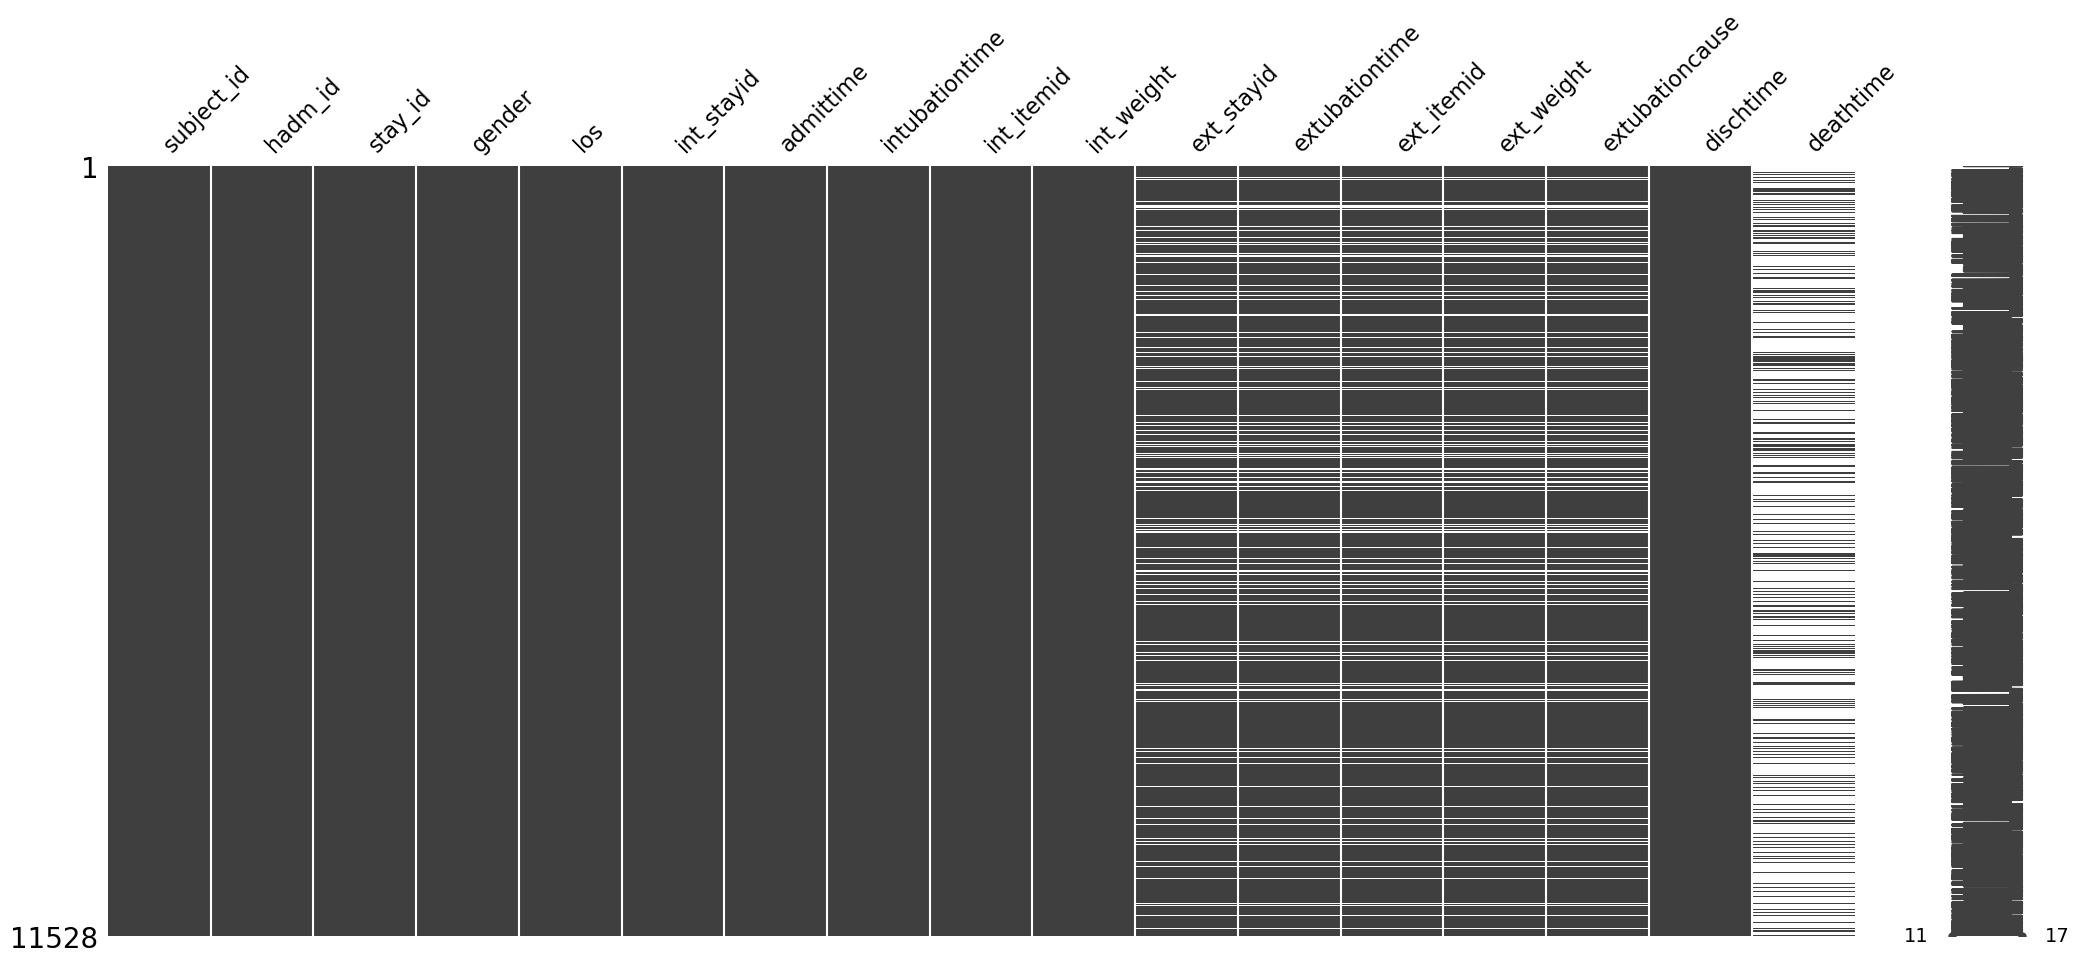

In [7]:
msno.matrix(joined_df)

### 2. intubation, extubation 페어링
- hadm_id 별로 그룹화하여 작업. 
- 한 hadm_id에 복수의 삽관 발관이 존재할 경우 페어링 로직 적용. (main_pairing) 
- 페어링이 이루어진 후에, 행마다 관련 변수들이 같이 따라와줘야함. (reformat_paired_data_to_dataframe)
    - 참고: 페어링이 다 이루어진 후에, 삽관시간과 발관시간이 동일한 데이터가 5개 확인되어 삭제함 (1월27일 논의사항 노션 참고)

In [8]:
def pair_data(df):
    start_time = time.time()   # 소요시간 계산
    
    # subject_id와 hadm_id로 그룹화
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    single_row_list = []
    reformatted_paired_dataframe_list = []

    # 데이터 1차 정리: single row processing, multirow pairing & reformatting
    for (subject_id, hadm_id), group in tqdm(grouped_df, desc="Pairing data..."):

        # single row processing
        # 해당 그룹(hadm_id)에 intubation 이벤트가 하나만 있는 경우 (즉, 페어링이 필요 없는 경우)
        if group['intubationtime'].count() == 1:
            # inttime, exttime 만 검증 후 데이터 통과
            time_mismatch = pairing.validate_single_rows(group)   # True 일 경우 통과. False일 경우 삭제
            if not time_mismatch:
                single_row_list.append(group)   # bypass single row event

        # 해당 그룹(hadm_id) 안에 여러 개의 intubation 이벤트가 있는 경우 (즉, 페어링이 필요한 경우)
        elif group['intubationtime'].count() > 1:
            # (subject_id, hadm_id) 그룹 내에서 고유한 intubationtime, extubationtime 값 추출
            unique_intubations = list(group['intubationtime'].dropna().unique())
            unique_extubations = list(group['extubationtime'].dropna().unique())

            pairs = pairing.main_pairing(unique_intubations, unique_extubations)   # 페어링 함수 적용

            # 페어링 완료 후 데이터 재구조화 (필요한 칼럼 가져오기)
            reformatted_paired_dataframe = pairing.reformat_paired_data_to_dataframe(group, pairs, subject_id, hadm_id)
            reformatted_paired_dataframe_list.append(reformatted_paired_dataframe)

    # 데이터프레임 결합하기
    combined_list = single_row_list + reformatted_paired_dataframe_list

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)  
        combined_df = pd.concat(combined_list, ignore_index=True)

    # 'subject_id', 'hadm_id', 'imputationtime' 순으로 정렬 (ascending=True)
    combined_df = combined_df.sort_values(by=['subject_id', 'hadm_id', 'intubationtime', 'extubationtime'], ascending=True)
    combined_df = combined_df.reset_index(drop=True)

    # 각 그룹별로 시퀀스 넘버링 해주기
    combined_df['seq_num'] = combined_df.groupby(['subject_id', 'hadm_id']).cumcount() + 1

    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))

    return combined_df

In [9]:
paired_df = pair_data(joined_df)
paired_df = paired_df[paired_df.intubationtime != paired_df.extubationtime]  # 오류 데이터 삭제 (상기 markdown, 노션 2024.01.27 논의사항 참고)

print(f'Processed paired_df: {paired_df.shape}')   # (9003, 19)
paired_df.columns

Pairing data...: 100%|████████████████████████████████████████████████████████████| 7087/7087 [00:21<00:00, 332.59it/s]


--- RUNTIME: 28.62 seconds ---
Processed paired_df: (9348, 19)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'int_stayid',
       'admittime', 'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num'],
      dtype='object')

In [10]:
paired_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9348 entries, 0 to 9352
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   subject_id       9348 non-null   int64         
 1   hadm_id          9348 non-null   int64         
 2   stay_id          7074 non-null   float64       
 3   gender           7074 non-null   object        
 4   los              7074 non-null   float64       
 5   int_stayid       8060 non-null   float64       
 6   admittime        9348 non-null   datetime64[ns]
 7   intubationtime   8060 non-null   datetime64[ns]
 8   int_itemid       8060 non-null   float64       
 9   int_weight       8060 non-null   float64       
 10  ext_stayid       6972 non-null   float64       
 11  extubationtime   6972 non-null   datetime64[ns]
 12  ext_itemid       6972 non-null   float64       
 13  ext_weight       6972 non-null   float64       
 14  extubationcause  6972 non-null   object      

In [11]:
# 1. Convert subject_id columns to Sets for efficient comparison
paired_ids = set(paired_df["subject_id"])
joined_ids = set(joined_df["subject_id"])

# 2. Find the difference (elements in joined_df but not in paired_df)
missing_ids = joined_ids.difference(paired_ids)

# 3. Print or use the missing_ids set for further analysis
print("Missing subject IDs in paired_df but present in joined_df:")
print(len(missing_ids))

Missing subject IDs in paired_df but present in joined_df:
349


In [12]:
joined_df[joined_df.subject_id.isin(missing_ids)]

,subject_id,hadm_id,stay_id,gender,los,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime
62,10123036,29540743,35987620,M,1.569468,30112389,2168-06-06 02:32:00,2168-06-08 03:36:00,224385,95.4,35987620.0,2168-06-06 11:27:00,227194.0,95.4,Planned Extubation,2168-06-19 18:00:00,NaT
136,10188428,22776014,31485736,F,4.954641,35715517,2176-11-24 23:07:00,2176-12-05 20:00:00,224385,70.5,31485736.0,2176-11-25 10:09:00,227194.0,70.5,Planned Extubation,2176-12-13 09:50:00,2176-12-13 09:50:00
254,10291112,28226328,31376532,F,15.147037,31376532,2151-11-29 16:12:00,2151-12-07 16:00:00,224385,50.0,31376532.0,2151-12-07 15:10:00,227194.0,50.0,Planned Extubation,2152-01-04 18:00:00,NaT
264,10297708,22677931,31999886,M,33.206933,31999886,2136-08-02 00:00:00,2136-08-15 18:15:00,224385,68.9,31999886.0,2136-08-08 16:25:00,227194.0,68.9,Planned Extubation,2136-09-10 14:30:00,NaT
324,10373824,27677881,34440488,F,18.810162,34440488,2139-07-12 08:29:00,2139-07-30 09:14:00,224385,50.0,34440488.0,2139-07-29 10:27:00,227194.0,50.0,Planned Extubation,2139-08-07 14:30:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11499,19986715,28333468,39855146,F,10.581933,30045509,2150-11-29 02:47:00,2150-12-16 12:30:00,224385,39.5,39855146.0,2150-12-08 09:30:00,227194.0,39.5,Planned Extubation,2151-01-14 14:20:00,NaT
11500,19989783,26984195,32761676,M,20.289306,32761676,2130-07-12 08:34:00,2130-07-19 16:50:00,224385,101.0,32761676.0,2130-07-19 12:40:00,227194.0,101.0,Planned Extubation,2130-08-01 15:50:00,NaT
11509,10011365,26712576,37153661,F,8.702697,37153661,2166-02-11 14:09:00,2166-02-14 17:59:00,224385,46.3,37153661.0,2166-02-14 09:48:00,227194.0,46.3,Planned Extubation,2166-02-20 00:20:00,2166-02-20 00:20:00
11511,10020944,29974575,30757476,M,9.076829,30757476,2131-02-27 15:34:00,2131-03-03 20:11:00,224385,107.0,30757476.0,2131-03-03 19:54:00,225468.0,107.0,Unplanned Extubation (patient-initiated),2131-03-13 17:01:00,NaT


In [13]:
paired_df.subject_id.nunique()

6360

In [15]:
paired_df

,subject_id,hadm_id,stay_id,gender,los,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,seq_num
0,10001884,26184834,37510196.0,F,9.171817,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,1
1,10003400,23559586,38383343.0,F,16.069838,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,1
2,10004401,27939719,31202136.0,M,2.523519,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,1
3,10004401,29988601,32773003.0,M,10.636238,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,1
4,10004401,29988601,NaN,NaN,NaN,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,None,2144-02-06 11:45:00,NaT,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9348,19997367,20617667,35616526.0,F,25.337569,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,None,2
9349,19997367,20617667,NaN,NaN,NaN,NaN,2126-04-20 07:15:00,NaT,NaN,NaN,35616526.0,2126-04-22 08:23:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,None,3
9350,19999068,21606769,30143796.0,M,6.765324,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,None,1
9351,19999442,26785317,32336619.0,M,6.950370,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,None,1


In [14]:
# 데이터 저장
paired_df.to_csv('./data/paired_df.csv')

In [6]:
# 데이터 재임포트
paired_df = pd.read_csv('./data/paired_df.csv', index_col=0, \
                        parse_dates=['intubationtime', 'extubationtime', \
                                     'admittime', 'dischtime', 'deathtime'])
paired_df = cls.create_stay_id(paired_df)   # stay id 만들기

print(paired_df.shape)   # (9003, 19)

(9348, 19)


In [7]:
# 결측치 현황
int_null_count = paired_df.intubationtime.isna().sum()
ext_null_count = paired_df.extubationtime.isna().sum()

row_null_count = (paired_df.intubationtime.isna() | paired_df.extubationtime.isna()).sum()   # int, ext 하나라도 null

print('EVENT 기준')
print(f'intubation NULL case: {int_null_count}')
print(f'extubation NULL case: {ext_null_count}')

print('')
print('ROW 기준')
print(f'NULL이 존재하는 행: {row_null_count}')
print(f'{round(row_null_count / paired_df.shape[0] * 100, 2)}%')


EVENT 기준
intubation NULL case: 1288
extubation NULL case: 2376

ROW 기준
NULL이 존재하는 행: 3664
39.2%


In [8]:
paired_df[paired_df.intubationtime.isna() | paired_df.extubationtime.isna()]

,subject_id,hadm_id,stay_id,gender,los,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,seq_num
2,10004401,27939719,31202136,M,2.523519,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,1
4,10004401,29988601,32773003,NaN,NaN,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,NaN,2
6,10007818,22987108,32359580,M,20.528681,32359580.0,2146-06-10 16:37:00,2146-06-22 12:49:00,224385.0,86.2,NaN,NaT,NaN,NaN,NaN,2146-07-12 00:00:00,2146-07-12 20:50:00,NaN,1
7,10010058,26359957,33060379,M,1.232326,33060379.0,2147-11-18 02:34:00,2147-11-18 02:35:00,224385.0,60.0,NaN,NaT,NaN,NaN,NaN,2147-11-19 04:00:00,2147-11-19 04:00:00,NaN,1
9,10017531,22580355,35526828,M,31.809965,35526828.0,2159-09-22 19:30:00,2159-09-23 16:01:00,224385.0,119.0,NaN,NaT,NaN,NaN,NaN,2159-10-24 13:40:00,NaT,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9342,19989918,20256395,35582926,NaN,NaN,NaN,2175-09-18 17:45:00,NaT,NaN,NaN,35582926.0,2175-09-26 16:00:00,227194.0,124.4,Planned Extubation,2175-09-28 17:45:00,NaT,NaN,2
9343,19990427,29695607,34058245,F,9.731713,34058245.0,2182-01-04 00:00:00,2182-01-14 04:21:00,224385.0,100.0,NaN,NaT,NaN,NaN,NaN,2182-01-24 00:00:00,2182-01-24 23:15:00,NaN,1
9346,19995595,21784060,34670930,NaN,NaN,NaN,2126-10-17 21:43:00,NaT,NaN,NaN,34670930.0,2126-10-30 14:26:00,227194.0,94.7,Planned Extubation,2126-11-12 17:35:00,NaT,NaN,2
9349,19997367,20617667,35616526,NaN,NaN,NaN,2126-04-20 07:15:00,NaT,NaN,NaN,35616526.0,2126-04-22 08:23:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,3


In [9]:
paired_df.intubationtime.isna().sum(), paired_df.extubationtime.isna().sum()

(1288, 2376)

In [10]:
def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, intext_duration, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.sort_ventilation_sequence(patient_df)   # 삽관/발관 시간 페어링
            patient_df = rnt.get_intext_duration(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['subject_id', 'hadm_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [11]:
reintubation_df = get_reintubation(paired_df)
print(f'Processed reintubation_df: {reintubation_df.shape}')   # (9000, 23)
reintubation_df.columns

Fetching reintubation data...: 100%|██████████| 6713/6713 [00:45<00:00, 149.00it/s]


--- RUNTIME: 47.55 seconds ---
Processed reintubation_df: (9348, 23)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'int_stayid',
       'admittime', 'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num', 'reint_marker',
       'intext_duration', 'reintubation_eventtime', 'reintubationtime'],
      dtype='object')

In [12]:
# 데이터 저장
reintubation_df.to_csv('./data/reintubation_df.csv', encoding='utf-8-sig')

#### 분류 코드

11    재삽관 없이 발관후 48시간 넘어 퇴원 | nonfailure

121   재삽관 없이 발관후 48시간 이내 사망 X | nonfailure

1221  재삽관 없이 발관후 24시간 이내 사망 | death

1222  재삽관 없이 발관후 24~48시간 이내 사망 | death

211   48시간 이내 재삽관 | failure

212   48시간 너머 재삽관 | nonfailure

221   최종 발관 이후 48시간 넘어 퇴원 | nonfailure

2221  최종 발관 이후 48시간 이내 사망 X | nonfailure

22221 최종 발관 이후 24시간 이내 사망 | death

22222 최종 발관 이후 24~48시간 이내 사망 | death

999   (null case)현발관-다음발관이 48시간 이내 | Failure

998   (null case)현삽관-다음삽관이 48시간 이내 | Failure

9999  (null case) non-failure 판단 불가 | 제거

In [17]:
# 데이터 임포트
reintubation_df = pd.read_csv('./data/reintubation_df.csv', index_col=0, \
                               parse_dates=['intubationtime', 'extubationtime', \
                                            'admittime', 'dischtime', 'deathtime'])

print(reintubation_df.shape)   # (9003, 23)

(9348, 23)


In [18]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 행별로 케이스 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)

    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [19]:
subjectlist1 = categorize_patients(reintubation_df)

# stayid_mismatch 칼럼 생성
subjectlist1 = util.mark_stayid_mismatch(subjectlist1)   # 삽관 발관 이벤트의 stay_id가 안 맞는 케이스를 마킹함.

subjectlist2 = subjectlist1[subjectlist1.mvtime == False]   # mvtime 제거

print(f'Processed subjectlist1: {subjectlist1.shape}')   # (9003, 31)
print(f'Processed subjectlist2: {subjectlist2.shape}')   # (6535, 31)

subjectlist1.columns

Categorizing extubation failure vs non-failure...: 100%|██████████| 6713/6713 [00:33<00:00, 197.69it/s]


--- RUNTIME: 37.10 seconds ---
Processed subjectlist1: (9348, 31)
Processed subjectlist2: (7438, 31)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'int_stayid',
       'admittime', 'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num', 'reint_marker',
       'intext_duration', 'reintubation_eventtime', 'reintubationtime',
       'mvtime', 'final_event', 'ext_to_death', 'ext_to_disch',
       'disch_to_death', 'class_code', 'class', 'stayid_mismatch'],
      dtype='object')

In [42]:
# # 비논리적 데이터 삭제
# subjectlist1 = subjectlist1[((subjectlist1.intext_duration.isna()) | (subjectlist1.intext_duration > 0)) &\
#               ((subjectlist1.reintubationtime.isna()) | (subjectlist1.reintubationtime >= 0))]

In [22]:
# subjectlist1[(subjectlist1.final_event == True) & (subjectlist1.extubationtime.isna())]   # 결측치 대체 검증 (아무 행도 없어야 정상)

,subject_id,hadm_id,stay_id,gender,los,int_stayid,admittime,intubationtime,int_itemid,int_weight,...,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
2,10004401,27939719,31202136,M,2.523519,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,...,NaN,NaN,False,True,NaN,NaN,NaN,9999,None,False
4,10004401,29988601,32773003,NaN,NaN,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,...,NaN,NaN,False,True,NaN,NaN,NaN,9999,None,False
6,10007818,22987108,32359580,M,20.528681,32359580.0,2146-06-10 16:37:00,2146-06-22 12:49:00,224385.0,86.2,...,NaN,NaN,False,True,NaN,NaN,1250.0,9999,None,False
7,10010058,26359957,33060379,M,1.232326,33060379.0,2147-11-18 02:34:00,2147-11-18 02:35:00,224385.0,60.0,...,NaN,NaN,False,True,NaN,NaN,0.0,9999,None,False
9,10017531,22580355,35526828,M,31.809965,35526828.0,2159-09-22 19:30:00,2159-09-23 16:01:00,224385.0,119.0,...,NaN,NaN,False,True,NaN,NaN,NaN,9999,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9324,19971771,26230047,38668070,F,25.483461,38668070.0,2117-04-26 00:21:00,2117-04-26 00:22:00,224385.0,90.0,...,NaN,NaN,False,True,NaN,NaN,NaN,9999,None,False
9329,19979469,29434840,37363141,M,3.177975,37363141.0,2202-02-22 18:26:00,2202-02-22 21:40:00,224385.0,86.0,...,NaN,NaN,False,True,NaN,NaN,NaN,9999,None,False
9331,19983257,21588174,31169972,NaN,NaN,31169972.0,2166-06-13 14:21:00,2166-06-19 09:20:00,224385.0,118.6,...,NaN,NaN,False,True,NaN,NaN,0.0,9999,None,False
9338,19990427,29695607,34058245,F,9.731713,34058245.0,2182-01-04 00:00:00,2182-01-14 04:21:00,224385.0,100.0,...,NaN,NaN,False,True,NaN,NaN,1395.0,9999,None,False


### 3. Subject list 추출
- 개념정리:
    - 지금까지는 hadm_id 기준으로 intubation, extubation 데이터를 정리했음.
        - 정리된 데이터는 'subjectlist1_intextevents.csv', subjectlist2_intextevents.csv' 파일로 저장됨.
    - 순전히 subject list 만 있는 데이터는 'sub1list', 'sub2list'로 저장됨.
    - 이 둘의 차이는 '행' 수의 차이. 'subjectlist1_intextevents.csv', subjectlist2_intextevents.csv' 파일의 경우, 한 hadm_id 내에서 여러번의 삽관/발관이 있을 수 있기 때문에, 고유한 환자리스트보다 행수가 더 많음. 
    - 반면, 'sub1list', 'sub2list'는 순전히 환자번호(subject_id)와 입원정보(hadm_id, stay_id, admittime, dischtime)만 있기 때문에, 행수가 더 적음.
        - 즉, 고유한 환자 리스트 (unique patient list).
    - 따라서 Feature 결합 시에는 이 테이블을 활용하는 것이 맞음.

In [24]:
subjectlist1

,subject_id,hadm_id,stay_id,gender,los,int_stayid,admittime,intubationtime,int_itemid,int_weight,...,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
0,10001884,26184834,37510196,F,9.171817,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,...,NaN,NaN,False,True,10775.0,10775.0,0.0,11,nonfailure,False
1,10003400,23559586,38383343,F,16.069838,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,...,NaN,NaN,False,True,17365.0,17365.0,0.0,11,nonfailure,False
2,10004401,27939719,31202136,M,2.523519,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,...,NaN,NaN,False,True,NaN,NaN,NaN,9999,None,False
3,10004401,29988601,32773003,M,10.636238,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,...,2144-01-30 13:00:00,30.0,False,False,NaN,10035.0,NaN,211,failure,False
4,10004401,29988601,32773003,NaN,NaN,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,...,NaN,NaN,False,True,NaN,NaN,NaN,9999,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9343,19997367,20617667,35616526,F,25.337569,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,...,2126-05-05 18:20:00,4430.0,False,False,NaN,24345.0,NaN,212,nonfailure,False
9344,19997367,20617667,35616526,F,25.337569,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,...,NaN,NaN,False,True,NaN,15646.0,NaN,221,nonfailure,False
9345,19999068,21606769,30143796,M,6.765324,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,...,NaN,NaN,False,True,NaN,7525.0,NaN,11,nonfailure,False
9346,19999442,26785317,32336619,M,6.950370,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,...,NaN,NaN,True,True,NaN,20290.0,NaN,11,nonfailure,False


In [25]:
# 데이터 저장
sub1list = subjectlist1 >> select('subject_id','hadm_id',\
                                  'stay_id', 'admittime', 'dischtime')
sub1list = sub1list.drop_duplicates(subset='stay_id')   # remove dup


sub2list = subjectlist2 >> select('subject_id','hadm_id',\
                                  'stay_id', 'admittime', 'dischtime')
sub2list = sub2list.drop_duplicates(subset='stay_id')   # remove dup


subjectlist1.to_csv('./data/subjectlist1_intextevents.csv')   # 삽관발관 포함
subjectlist2.to_csv('./data/subjectlist2_intextevents.csv')   # 삽관발관 포함
sub1list.to_csv('./data/sub1list.csv')   # 고유 환자리스트
sub2list.to_csv('./data/sub2list.csv')   # 고유 환자리스트



In [26]:
sub1list.shape

(7251, 5)

### 4. subject 데이터 요약

In [27]:
subject_count = sub1list.subject_id.nunique()   # 환자 수

print(f'UNIQUE SUBJECTS: {subject_count}')
print(subjectlist1.class_code.value_counts())
print(f'SUM: {subjectlist1.class_code.value_counts().sum()}')

UNIQUE SUBJECTS: 6360
class_code
11       2824
9999     2313
211      1103
221      1088
212       723
1221      411
998       274
22221     202
999       175
121       110
1222       50
2221       39
22222      36
Name: count, dtype: int64
SUM: 9348


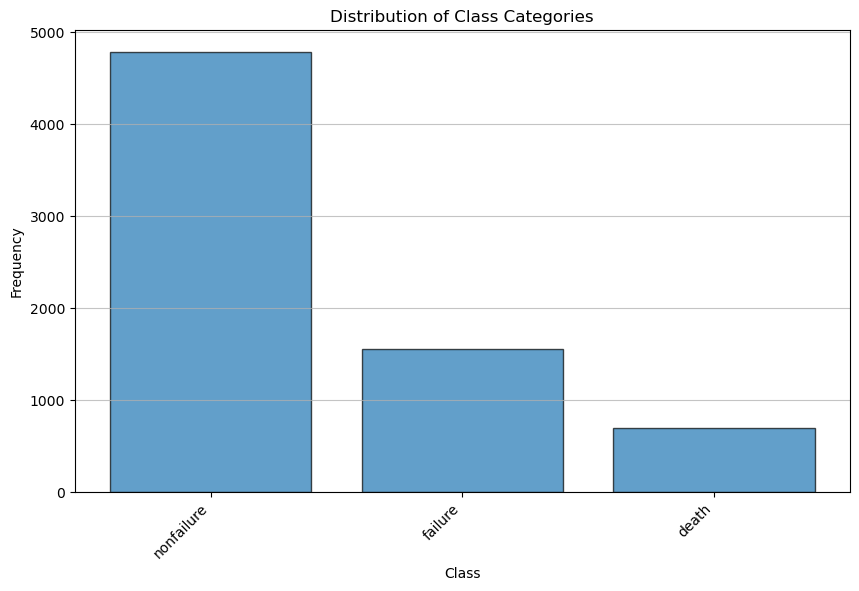

class
nonfailure    4784
failure       1552
death          699
Name: count, dtype: int64
TOTAL: 7035


In [28]:
# Class 별로 (Non-failure, Death, Failure) 빈도 확인
class_counts = subjectlist1['class'].value_counts()

# bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

print(class_counts)
print(f'TOTAL: {class_counts.sum()}')

In [29]:
sub1list

,subject_id,hadm_id,stay_id,admittime,dischtime
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00
5,10005817,28661809,31316840,2135-01-03 21:54:00,2135-01-19 18:36:00
...,...,...,...,...,...
9340,19995595,21784060,34670930,2126-10-17 21:43:00,2126-11-12 17:35:00
9342,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00
9345,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00
9346,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00
